In [1]:
import utils.data as data
import utils.stats as stats
import numpy as np
import matplotlib.pyplot as plt


Loading data from:
	data\ugr16\raw.csv
Number of packets: 1000000
Trace duration: 1342.636 seconds
Time unit 1.0e-01 has 11706 bars
(11706,)
1342.636
(13428,)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[2. 0. 0. 0. 0. 0. 4. 1. 1. 2.]
Loading data from:
	data\ugr16\syn.csv
Number of packets: 1051363
Trace duration: 1847.78589625 seconds
Time unit 1.0e-01 has 12889 bars
(12889,)
1847.78589625
(18479,)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]


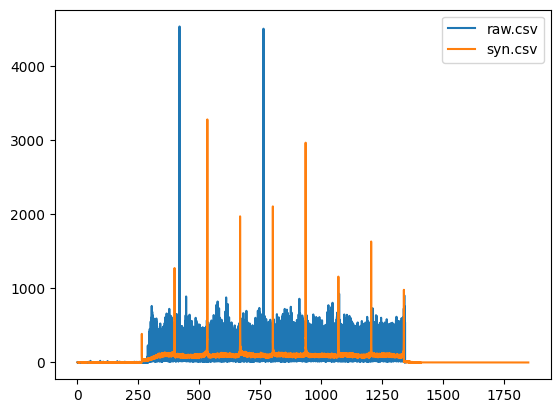

In [2]:
def tmp(dataset, filename, time_unit_exp):
    df = data.load_data(dataset, filename, verbose=False)
    total_duration = df["time"].max()
    # 6: TCP, 17: UDP
    # df = df[(df["proto"] == "TCP") | (df["proto"] == 6)]
    # df = df[df["type"] == "background"]
    # df = df[df["type"] == "blacklist"]

    # compute the packet counts
    timestamps, pkt_counts = stats.pkt_count(
        df, time_unit_exp, total_duration, all_unit=True, verbose=True)

    print(timestamps[:10])
    print(pkt_counts[:10])

    plt.plot(timestamps, pkt_counts, label=filename)
    # plt.plot(stats.autocorr(pkt_counts), label=filename)

    return 

tmp("ugr16", "raw.csv", np.log10(0.1))
tmp("ugr16", "syn.csv", np.log10(0.1))
# tmp("ugr16", "syn_stan_raw.csv", -2)
# tmp("ugr16", "syn_stan_netshare.csv", -2)

plt.legend()
del tmp

Loading data from:
	data\ugr16\raw.csv
Number of packets: 1000000
Trace duration: 1342.636 seconds
Time unit 1.0e-01 has 11706 bars
(11706,)
1342.636
(13428,)
Time unit 1.0e-01 has 11706 bars
(13428,)
Loading data from:
	data\ugr16\syn.csv
Number of packets: 1051363
Trace duration: 1847.78589625 seconds
Time unit 1.0e-01 has 12889 bars
(12889,)
1847.78589625
(18479,)
Time unit 1.0e-01 has 12889 bars
(18479,)


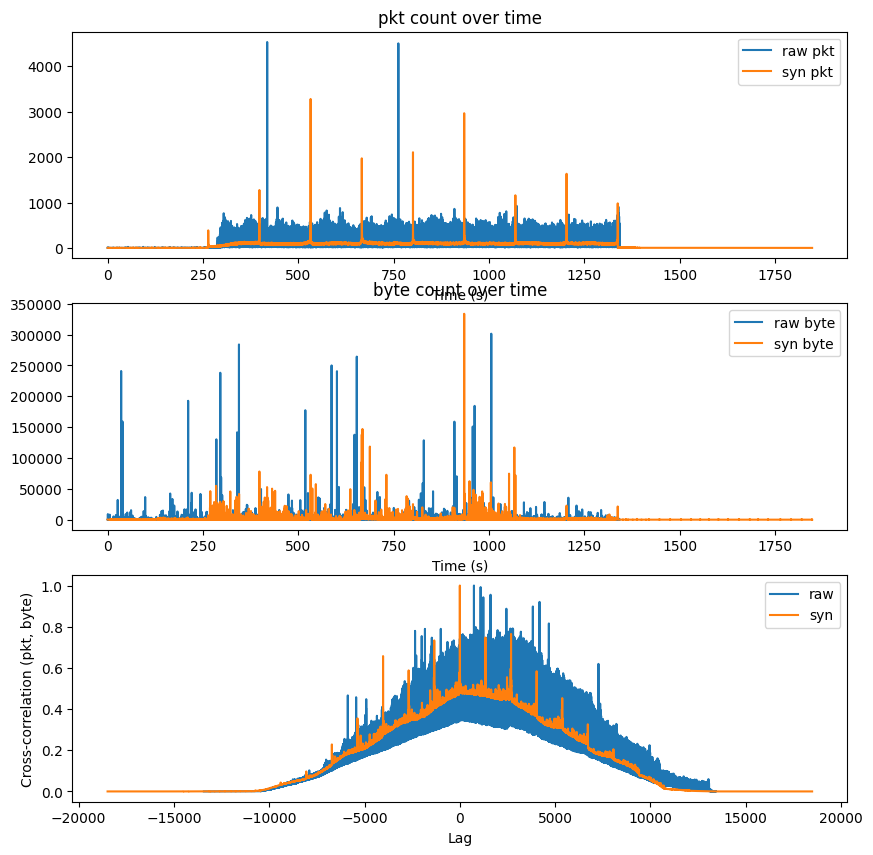

In [5]:
def pkt_byte_corr_cmp(dataset, time_unit_exp=1):
    filename = "raw.csv"

    # Load the data
    df = data.load_data(dataset, filename, verbose=False)
    total_duration = df["time"].max()

    # Compute the packet counts and its hurst exponent
    timestamps, pkt_counts = stats.pkt_count(df, time_unit_exp, total_duration, all_unit=True)
    timestamps, byte_counts = stats.byte_count(df, time_unit_exp, total_duration, all_unit=True)

    cross_corr = stats.cross_corr(pkt_counts, byte_counts)

    fig, axes = plt.subplots(3, 1, figsize=(10, 10))

    axes[0].plot(timestamps, pkt_counts, label="raw pkt")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_title("pkt count over time")

    axes[1].plot(timestamps, byte_counts, label="raw byte")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_title("byte count over time")

    axes[2].plot(np.arange(len(cross_corr))-len(cross_corr)//2, cross_corr, label="raw")
    axes[2].set_xlabel("Lag")
    axes[2].set_ylabel("Cross-correlation (pkt, byte)")


    filename = "syn.csv"
    # Load the data
    df = data.load_data(dataset, filename, verbose=False)
    total_duration = df["time"].max()

    # Compute the packet counts and its hurst exponent
    timestamps, pkt_counts = stats.pkt_count(df, time_unit_exp, total_duration, all_unit=True)
    timestamps, byte_counts = stats.byte_count(df, time_unit_exp, total_duration, all_unit=True)
    cross_corr = stats.cross_corr(pkt_counts, byte_counts)

    axes[0].plot(timestamps, pkt_counts, label="syn pkt")
    axes[0].legend()

    axes[1].plot(timestamps, byte_counts, label="syn byte")
    axes[1].legend()

    axes[2].plot(np.arange(len(cross_corr))-len(cross_corr)//2, cross_corr, label="syn")
    axes[2].legend()

    # axes[2].set_ylim(-1, 1)

pkt_byte_corr_cmp("ugr16", time_unit_exp=-1)

In [ ]:
def pca_vis(dataset, filename, time_unit_exp, n_components=9):
    df = data.load_data(dataset, filename, verbose=False)
    total_duration = df["time"].max()

    dfg = df.groupby(stats.five_tuple)

    _, _, U, Sigma, _ = stats.flow_pca(dfg, dfg.group_keys, total_duration, time_unit_exp, n_components)
    sigma_order = np.argsort(Sigma)

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))

    timestamps = np.arange(0, total_duration, 10**time_unit_exp)

    for i in range(np.min([n_components, 9])):
        axes[i//3, i%3].plot(timestamps, U[:, sigma_order[i]])
        axes[i//3, i%3].set_title(Sigma[sigma_order[i]])


pca_vis("caida", "raw.csv", -5, 9) 